# Behavioral Cloning Project

This notebook comprises the model building. I largely prefer this way of develoment. For completeness I included in the repository the downloaded notebook file and renamed it to ``model.py``. However the attached model and figures were created with this notebook run. 

This notebook consists of the following sections: 
- Setting: Respective settings of the process can be adjusted an set
- Data: Describes collection, loading and augmentation
- Network: Model building
- Training: Carry out learning phase

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display

In [2]:
import tensorflow as tf
import keras
print("keras:", keras.__version__)
print("GPU:", tf.test.is_gpu_available())

Using TensorFlow backend.


keras: 2.0.9
GPU: True


# Setting

In [3]:
# data setting
DATA_FOLDERS = [
    # "./data/track1_run2/", 
    "./data/track1_run2/", 
    "./data/track1_run3/"
]
# augment with left and right views and its steering correction
AUG_SIDE_IMAGES = True  
CORRECTION = 0.12
# augment with left-right flipped images
AUG_FLIP_LR = True

# network
INPUT_SHAPE = [160, 320, 3]
CROPPING = ((60, 20), (0, 0))

# training 
EPOCHS = 5
VALIDATION_SPLIT = 0.2

# other
SAVE_IMGS = 2
DOC_FOLDER = "./examples/"
MODEL_FILEPATH = "model.h5"

# Data

## Collection

Via the simulator the following datasets were collected:

- data_run1: Track 1 original direction
- data_run2: Track 2 original direction
- data_run3: Track 3 reverse direction

Each set consists of a single lap where I tried to drive center focused. I had to restart this a couple of times because in particular in the curves this was challenging and I did not want to create bad data. Note those data files are not part of the repository.

In [4]:
colnames = ['center', 'left', 'right', 'steering', 'throttle', 'brake' ,'speed']
l_data = []
for folder in DATA_FOLDERS:
    data = pd.read_csv(os.path.join(folder, "driving_log.csv"), names=colnames)
    l_data.append(data)
data = pd.concat(l_data)
display(data.sample(5))

,center,left,right,steering,throttle,brake,speed
789,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,0.041667,0.4,0,30.03817
310,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,-0.109375,0.4,0,30.03785
610,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,0.036458,0.4,0,30.03807
71,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,0.276042,0.4,0,30.03646
335,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,E:\Trainings\CarND\CarND-Behavioral-Cloning-P3...,-0.062500,0.4,0,30.03820


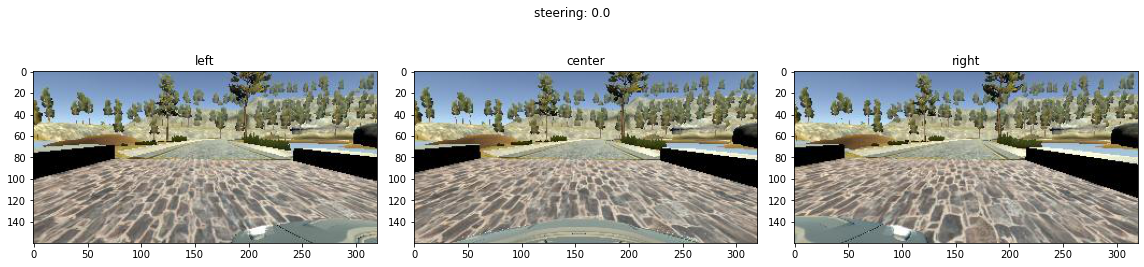

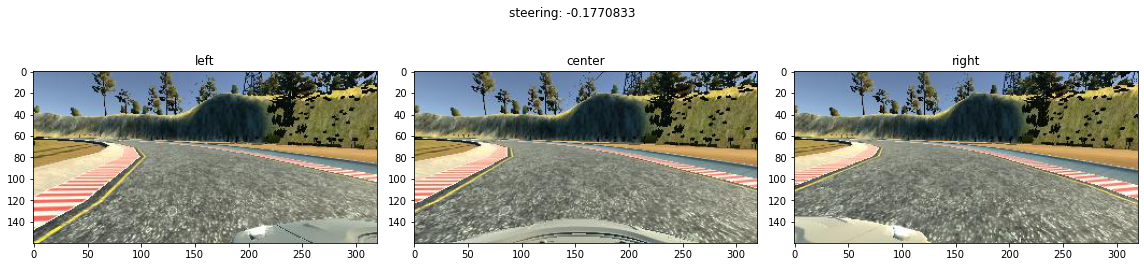

In [5]:
# plot some original recorded images

for num in range(SAVE_IMGS):
    rec = data.sample().iloc[0]
    fig = plt.figure(figsize=(16, 4))
    for i, pos in enumerate(['left', 'center', 'right'], start=1):
        plt.subplot(1, 3, i)
        img = mpimg.imread(rec[pos])
        plt.imshow(img)
        plt.title(pos)
    plt.suptitle(f"steering: {rec.steering}")
    plt.tight_layout()
    plt.savefig(os.path.join(DOC_FOLDER, f"orig_images_{num}.jpg"))

## Loading
- Load center images
- Optionally add left and right camera view images with corrected steering values
- Optionally add left-right flipped images

Note, images and measurement still fit easily in memory. So I did not see any point using a generator.

In [6]:
images = np.asarray([mpimg.imread(img_path) for img_path in data['center']])
measurements = data['steering'].values

if AUG_SIDE_IMAGES:    
    images_left = np.asarray([mpimg.imread(img_path) for img_path in data['left']])
    measurements_left = data['steering'].values + CORRECTION
    images_right = np.asarray([mpimg.imread(img_path) for img_path in data['right']])
    measurements_right = data['steering'].values - CORRECTION
    images = np.concatenate([images, images_left, images_right])
    measurements = np.concatenate([measurements, measurements_left, measurements_right])
    
if AUG_FLIP_LR:
    images_flipped = np.fliplr(images)
    measurments_flipped = -measurements
    images = np.concatenate([images, images_flipped])
    measurements = np.concatenate([measurements, measurments_flipped])    

In [7]:
X = images
y = measurements
print("X.shape:", X.shape, "X.dtype:", X.dtype)
print("y.shape:", y.shape, "y.dtype:", y.dtype)

X.shape: (14724, 160, 320, 3) X.dtype: uint8
y.shape: (14724,) y.dtype: float64


# Network

Following the course material I was slowly progressing thru different network architectures, starting with a simple feed-forward network, and then moving to LeNet5. Finally I used the network from the mentioned [NVIDIA paper](./literature/end-to-end-dl-using-px.pdf) (I included a copy in this repository). Additionally I cropped the input to focus only on the road. This was already providing excellent results.

In [8]:
from keras import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, AvgPool2D, Cropping2D, Dropout

In [9]:
keras.backend.clear_session()
model = Sequential()
model.add(Cropping2D(cropping=CROPPING, input_shape=INPUT_SHAPE))
model.add(Lambda(lambda x: x / 255. - 0.5))
model.add(Conv2D(24, 5, strides=2, activation='relu'))
model.add(Conv2D(36, 5, strides=2, activation='relu'))
model.add(Conv2D(48, 5, strides=2, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Conv2D(64, 3, activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 158, 24)       1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 77, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 37, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 35, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 33, 64)         36928     
__________

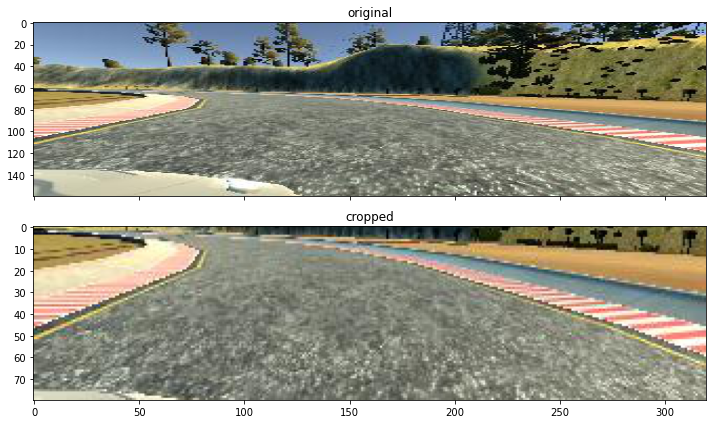

In [10]:
if SAVE_IMGS:
    crop_model = keras.Model(inputs=model.input, outputs=model.layers[0].output)
    img_crop = crop_model.predict(np.expand_dims(img, 0))[0]
    img_crop = img_crop.astype('uint8')
    fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
    ax0.imshow(img, aspect='auto')
    ax0.set_title('original')
    ax1.imshow(img_crop, aspect='auto')
    ax1.set_title('cropped')
    plt.savefig(os.path.join(DOC_FOLDER, f"cropped_image.jpg"))
    plt.tight_layout()
    plt.show()

# Run Training

Training is carried out on the mean-squared-error loss function and using the Adam optimizer with default setting. A certain random fraction of data is used as validation set. On this I observe that only a few epochs are required before degradation. I employ the Keras model checkpointer callback to only save the best model.

In [11]:
from keras.callbacks import ModelCheckpoint

In [12]:
model.compile(loss='mse', optimizer='adam')

In [13]:
checkpointer = ModelCheckpoint(
    filepath=MODEL_FILEPATH, 
    save_best_only=True,
    monitor="val_loss", 
    verbose=True
)

In [14]:
hist = model.fit(
    X,
    y,
    epochs=EPOCHS,
    shuffle=True,
    validation_split=VALIDATION_SPLIT,
    callbacks=[checkpointer],
)

Train on 11779 samples, validate on 2945 samples
Epoch 1/5
11779/11779 [==============================] - 14s 1ms/step - loss: 0.0077 - val_loss: 0.0085
Epoch 2/5
11779/11779 [==============================] - 13s 1ms/step - loss: 0.0029 - val_loss: 0.0086
Epoch 3/5
11779/11779 [==============================] - 13s 1ms/step - loss: 0.0019 - val_loss: 0.0059
Epoch 4/5
11779/11779 [==============================] - 14s 1ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 5/5
11779/11779 [==============================] - 14s 1ms/step - loss: 0.0011 - val_loss: 0.0051


In [15]:
history_frame = pd.DataFrame(hist.history)
history_frame.index = pd.RangeIndex(1, len(history_frame) + 1, name="Epoch")
display(history_frame.style.highlight_min(color='lightgreen', subset=['val_loss']))

,val_loss,loss
Epoch,,
1,0.008550,0.007726
2,0.008580,0.002919
3,0.005905,0.001928
4,0.008455,0.001344
5,0.005084,0.001080


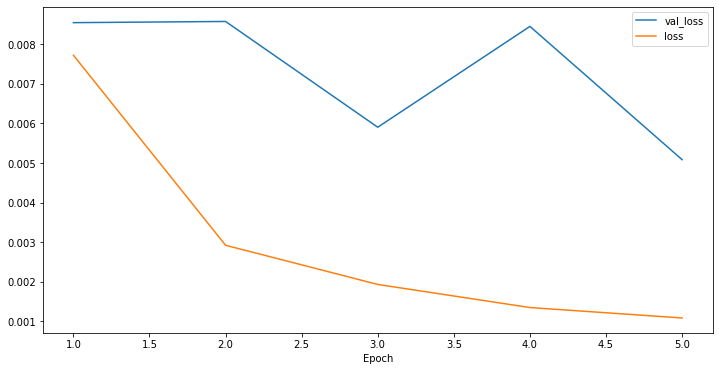

In [16]:
if SAVE_IMGS:
    history_frame.plot(figsize=(12, 6))
    plt.savefig(os.path.join(DOC_FOLDER, f"history.jpg"))